# Training GPT-2 model on Bangla books

Necessary imports for the project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from transformers import WEIGHTS_NAME, CONFIG_NAME
from tqdm import tqdm

## Preparing dataset
Initialize the project root, data, and model directories. `processed_data` directory contains selected books from renowned authors only.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_dir = project_root / 'models/bn_gpt2'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [4]:
random.shuffle(filenames)
filenames = filenames[:100]

`create_dataset` creates inputs and labels dataset of `max_sequence_length - 1` from a list of files using `tokenizer`.

In [22]:
def create_dataset(tokenizer, filenames, max_sequence_length):
    # create inputs and labels
    inputs = []
    labels = []

    for file in tqdm(filenames):
        with open(file, 'r') as f:
            for line in f:
                string_tokenized = tokenizer.encode(line)
                # create a list of block size tokens
                examples = []
                BATCH_SIZE = 12
                BUFFER_SIZE = 1000
                for i in range(0, len(string_tokenized) - max_sequence_length + 1, max_sequence_length):
                    ex = string_tokenized[i:i + max_sequence_length]
                    inputs.append(ex[:-1])
                    labels.append(ex[1:])
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    return dataset

Create a tokenizer from pretrained model and add special tokens for padding, beginning, and end of sentence.

In [18]:
tokenizer = AutoTokenizer.from_pretrained("flax-community/gpt2-bengali")
tokenizer.add_special_tokens(
    {'pad_token': '<pad>', 'bos_token': '<s>', 'eos_token': '</s>'})

3

Now we call the `create_dataset` with `MAX_SEQUENCE_LENGTH` on the list of files and store in `full_dataset`.

In [24]:
MAX_SEQUENCE_LENGTH = 200
full_dataset = create_dataset(tokenizer, filenames, MAX_SEQUENCE_LENGTH)

100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


In [27]:
DATASET_SIZE = full_dataset.cardinality().numpy()

Now we create training, validation and testing dataset from the full dataset with 70/15/15 split. We are following this [answer](https://stackoverflow.com/a/51258695/9495110) on Stack Overflow.

In [29]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

## Creating Model

Load pretrained GPT2 model and create model parameters: optimizer, loss and metrics

In [30]:
model = TFGPT2LMHeadModel.from_pretrained('flax-community/gpt2-bengali', from_pt=True)
# create model parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(loss=[loss, *[None] * model.config.n_layer], optimizer=adam, metrics=[metric])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.3.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

Create a checkpoint to save the best model that has the lowest loss.

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_dir),
                                                monitor='loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

Train on `train_dataset` for some epochs.

In [32]:
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=3, batch_size=64, callbacks=[checkpoint])

Epoch 1/3
3105/3105 [==============================] - ETA: 0s - loss: 1.5953 - logits_loss: 1.5953 - logits_accuracy: 0.6092 - past_key_values_1_accuracy: 1.3935e-04 - past_key_values_2_accuracy: 1.3146e-04 - past_key_values_3_accuracy: 2.2674e-05 - past_key_values_4_accuracy: 2.4731e-04 - past_key_values_5_accuracy: 1.6256e-04 - past_key_values_6_accuracy: 2.4474e-04 - past_key_values_7_accuracy: 1.2571e-04 - past_key_values_8_accuracy: 1.4062e-04 - past_key_values_9_accuracy: 1.0640e-04 - past_key_values_10_accuracy: 3.5148e-04 - past_key_values_11_accuracy: 1.0377e-04 - past_key_values_12_accuracy: 1.5283e-04
Epoch 1: loss improved from inf to 1.59535, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_gpt2


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


3105/3105 [==============================] - 2222s 714ms/step - loss: 1.5953 - logits_loss: 1.5953 - logits_accuracy: 0.6092 - past_key_values_1_accuracy: 1.3935e-04 - past_key_values_2_accuracy: 1.3146e-04 - past_key_values_3_accuracy: 2.2674e-05 - past_key_values_4_accuracy: 2.4731e-04 - past_key_values_5_accuracy: 1.6256e-04 - past_key_values_6_accuracy: 2.4474e-04 - past_key_values_7_accuracy: 1.2571e-04 - past_key_values_8_accuracy: 1.4062e-04 - past_key_values_9_accuracy: 1.0640e-04 - past_key_values_10_accuracy: 3.5148e-04 - past_key_values_11_accuracy: 1.0377e-04 - past_key_values_12_accuracy: 1.5283e-04 - val_loss: 1.9056 - val_logits_loss: 1.9056 - val_logits_accuracy: 0.5449 - val_past_key_values_1_accuracy: 1.3228e-04 - val_past_key_values_2_accuracy: 1.3133e-04 - val_past_key_values_3_accuracy: 1.6584e-05 - val_past_key_values_4_accuracy: 2.0935e-04 - val_past_key_values_5_accuracy: 1.7000e-04 - val_past_key_values_6_accuracy: 2.5062e-04 - val_past_key_values_7_accuracy: 1

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


3105/3105 [==============================] - 2194s 707ms/step - loss: 1.4321 - logits_loss: 1.4321 - logits_accuracy: 0.6404 - past_key_values_1_accuracy: 1.3435e-04 - past_key_values_2_accuracy: 1.3543e-04 - past_key_values_3_accuracy: 2.2731e-05 - past_key_values_4_accuracy: 2.2126e-04 - past_key_values_5_accuracy: 1.6917e-04 - past_key_values_6_accuracy: 2.6126e-04 - past_key_values_7_accuracy: 1.3451e-04 - past_key_values_8_accuracy: 1.4185e-04 - past_key_values_9_accuracy: 1.1189e-04 - past_key_values_10_accuracy: 3.2658e-04 - past_key_values_11_accuracy: 1.0359e-04 - past_key_values_12_accuracy: 1.7130e-04 - val_loss: 1.8989 - val_logits_loss: 1.8989 - val_logits_accuracy: 0.5470 - val_past_key_values_1_accuracy: 1.3754e-04 - val_past_key_values_2_accuracy: 1.3822e-04 - val_past_key_values_3_accuracy: 1.8365e-05 - val_past_key_values_4_accuracy: 2.0697e-04 - val_past_key_values_5_accuracy: 1.6204e-04 - val_past_key_values_6_accuracy: 2.8363e-04 - val_past_key_values_7_accuracy: 1

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/assets


3105/3105 [==============================] - 2188s 705ms/step - loss: 1.2873 - logits_loss: 1.2873 - logits_accuracy: 0.6702 - past_key_values_1_accuracy: 1.3276e-04 - past_key_values_2_accuracy: 1.3582e-04 - past_key_values_3_accuracy: 2.3096e-05 - past_key_values_4_accuracy: 2.1047e-04 - past_key_values_5_accuracy: 1.6842e-04 - past_key_values_6_accuracy: 2.5936e-04 - past_key_values_7_accuracy: 1.3645e-04 - past_key_values_8_accuracy: 1.4026e-04 - past_key_values_9_accuracy: 1.1334e-04 - past_key_values_10_accuracy: 3.2078e-04 - past_key_values_11_accuracy: 1.0936e-04 - past_key_values_12_accuracy: 1.7006e-04 - val_loss: 1.9300 - val_logits_loss: 1.9300 - val_logits_accuracy: 0.5458 - val_past_key_values_1_accuracy: 1.3170e-04 - val_past_key_values_2_accuracy: 1.3173e-04 - val_past_key_values_3_accuracy: 1.9859e-05 - val_past_key_values_4_accuracy: 2.0254e-04 - val_past_key_values_5_accuracy: 1.7351e-04 - val_past_key_values_6_accuracy: 2.8020e-04 - val_past_key_values_7_accuracy: 1

Training each epoch took around 30 minutes. Now we save the history for later use.

In [33]:
with open(str(model_dir / 'history'), 'wb') as file_pi:
    pickle.dump(history, file_pi)

INFO:tensorflow:Assets written to: ram://cfafe805-3fc2-407f-b2c4-83abf83d062b/assets


INFO:tensorflow:Assets written to: ram://cfafe805-3fc2-407f-b2c4-83abf83d062b/assets


And also save the model and tokenizer.

In [34]:
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(model_dir, WEIGHTS_NAME)
output_config_file = os.path.join(model_dir, CONFIG_NAME)
# save model and model configs
model.save_pretrained(model_dir)
model_to_save.config.to_json_file(output_config_file)
# save tokenizer
tokenizer.save_pretrained(model_dir)

('/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer_config.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/special_tokens_map.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/vocab.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/merges.txt',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/added_tokens.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer.json')

Finally we evaluate the model on `test_dataset`

In [35]:
model.evaluate(test_dataset, batch_size=1024)

665/665 [==============================] - 176s 264ms/step - loss: 1.7481 - logits_loss: 1.7481 - logits_accuracy: 0.5847 - past_key_values_1_accuracy: 1.2977e-04 - past_key_values_2_accuracy: 1.2350e-04 - past_key_values_3_accuracy: 1.7317e-05 - past_key_values_4_accuracy: 2.0151e-04 - past_key_values_5_accuracy: 1.6520e-04 - past_key_values_6_accuracy: 2.7618e-04 - past_key_values_7_accuracy: 1.1983e-04 - past_key_values_8_accuracy: 1.4176e-04 - past_key_values_9_accuracy: 1.1251e-04 - past_key_values_10_accuracy: 3.2194e-04 - past_key_values_11_accuracy: 9.4510e-05 - past_key_values_12_accuracy: 1.3549e-04


[1.7480930089950562,
 1.7480930089950562,
 0.5847023129463196,
 0.00012977376172784716,
 0.00012350284669082612,
 1.7317162928520702e-05,
 0.00020150879572611302,
 0.0001651952334214002,
 0.00027618248714134097,
 0.00011982951400568709,
 0.00014176458353176713,
 0.00011250907846260816,
 0.0003219417994841933,
 9.450972720514983e-05,
 0.0001354936684947461]

The first value in the list is the loss, and the 3rd one is the accuracy.

## Plotting the training accuracy and loss

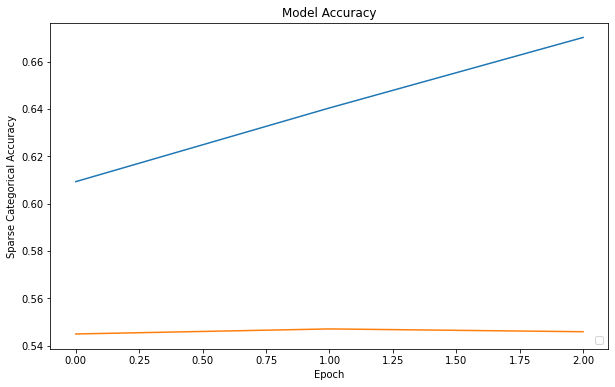

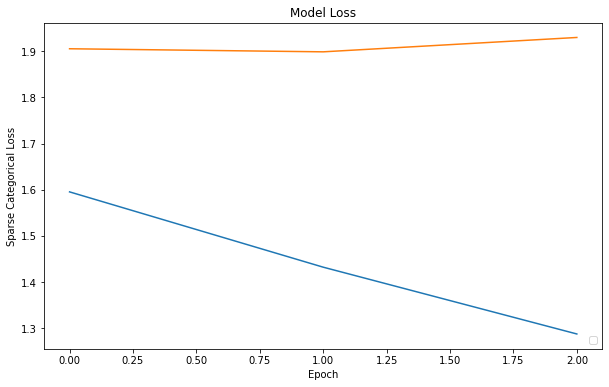

In [37]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_accuracy'])
plt.plot(history.history['val_logits_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(loc='lower right')
fig.savefig(str(model_dir / 'logits_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_loss'])
plt.plot(history.history['val_logits_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Loss')
plt.legend(loc='lower right')
fig.savefig(str(model_dir / 'logits_loss.png'), dpi=fig.dpi)

## Testing the model with actual data

Load the tokenizer and the model first if not already loaded

In [38]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = TFGPT2LMHeadModel.from_pretrained(str(model_dir))

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /home/shafquat/bangla-next-word-prediction/models/bn_gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


The function `generate_text` takes as input text, model, and tokenizer and generates top 5 texts with sampling `top_k` of 50 and `top_p` of 0.95. More on these sampling can be found on this [blog post](https://huggingface.co/blog/how-to-generate).

In [39]:
def generate_text(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='tf')
    outputs = model.predict(input_ids).logits

    print("Next most probable tokens:\n" + 100 * '-')
    for i in range(outputs.shape[1]):
        pred_id = np.argmax(outputs[:, i, :]).item()
        print(tokenizer.decode(pred_id))
    
    beam_outputs = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=5,
        early_stopping=True,
        do_sample=True,
        top_k=50,
        top_p=0.95,
    )

    print("Beam Output:\n" + 100 * '-')
    for i, beam_output in enumerate(beam_outputs):
        print("{}: {}".format(i, tokenizer.decode(
            beam_output, skip_special_tokens=True)))

Let's test our model for different texts using this function

In [45]:
text = input("Enter text: ")
generate_text(text, model, tokenizer)

Enter text: আমি


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Next most probable tokens:
----------------------------------------------------------------------------------------------------
ি
 ত
Beam Output:
----------------------------------------------------------------------------------------------------
0: আমি তোমার কাছে ক্ষমা চাইছি। মাওলানা মহিউদ্দিন সাহেব একটা দীর্ঘশ্বাস ফেললেন। তারপর মুখ ঘুরিয়ে নিজের বাড়ির দিকে চলে গেল। নাওয়ের পাটাতনে বসল বসে
1: আমি তোমার কাছে ক্ষমা চাইছি। তুমি যে অন্যায় করেছ তা আমি জানি। কিন্তু সেটা নিজের অপরাধ হিসাবে নেব না। বিয়ার পর থেকেই কেন জেল খাটছি আমি, কোনও কথা বল
2: আমি তোমার কাছে ক্ষমা চাইলাম। আল্লাহপাকের শুকরিয়া আদায় করছি যে তিনি আমাদিগকে রক্ষা করিলেন, যাহাতে পৃথিবীর মানুষকে নিরাপত্তা দেওয়ার জন্যে
3: আমি কী করুম? কাইল বিয়াইন্না রাইত্রের পর থিকা আমি তোমার মিহি চাইয়া রইছি। ক্যা? হেইডা জানি নাই। তয় মাঝিবাড়ির পোলাপানডির লেইগা কোনওদিন কিছু অয় ন
4: আমি তোমারে বিয়া করতে চাই। হেইডা আমি জানি। তয় তুমি যেই চেষ্টা করো না ক্যা? তারবাদেও যুদি কোনও অসুবিদা থাকে তেইল্লা দিমু। মাইয়ার বাপের কাছ থি


## Converting tensorflow model to tflite format

Set converter parameters to convert the model with FP16 quantization

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Now convert the model and save as `.tflite` file

In [42]:
tflite_model = converter.convert()
# Save the model.
with open(model_dir / 'bn_gpt2_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpps55w12r/assets


INFO:tensorflow:Assets written to: /tmp/tmpps55w12r/assets
2022-04-02 20:10:35.560721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-02 20:10:35.560742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-02 20:10:35.561340: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpps55w12r
2022-04-02 20:10:35.596419: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-02 20:10:35.596441: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpps55w12r
2022-04-02 20:10:35.727310: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-02 20:10:36.280661: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpps55w12r
2022-04-02 20:10:36.565960: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

This model can be used with android applications